In [143]:
!pip install captcha
!pip install Pillow
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [144]:
!rm -rf images



In [145]:
!git clone https://github.com/JackonYang/captcha-tensorflow.git

Cloning into 'captcha-tensorflow'...
remote: Enumerating objects: 427, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 427 (delta 38), reused 63 (delta 24), pack-reused 337
Receiving objects: 100% (427/427), 4.98 MiB | 12.41 MiB/s, done.
Resolving deltas: 100% (207/207), done.


In [146]:
!python captcha-tensorflow/datasets/gen_captcha.py -d --npi 4 -n 6

10 choices: 0123456789
generating 6 epoches of captchas in ./images/char-4-epoch-6/train.
(1/6) epoches finished
(2/6) epoches finished
(3/6) epoches finished
(4/6) epoches finished
(5/6) epoches finished
(6/6) epoches finished
write meta info in ./images/char-4-epoch-6/meta.json


In [147]:
DATA_DIR = './images/char-4-epoch-6/train'
H, W, C = 100, 120, 3  # height, width, 3(RGB channels)
N_LABELS = 256
D = 4 # num_per_image

In [148]:
def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        label, _ = filename.split("_")
        return label
    except Exception as e:
        print('error to parse %s. %s' % (filepath, e))
        return None, None

In [149]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import os
import time
import json
import glob

import matplotlib.pyplot as plt
from PIL import Image

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

In [150]:
# create a pandas data frame of images, age, gender and race
files = glob.glob(os.path.join(DATA_DIR, "*.png"))
attributes = list(map(parse_filepath, files))

df = pd.DataFrame(attributes)
df['file'] = files
df.columns = ['label', 'file']
df = df.dropna()
df

,label,file
0,0123,./images/char-4-epoch-6/train/0123_4891df83-c2...
1,0124,./images/char-4-epoch-6/train/0124_14884344-b3...
2,0125,./images/char-4-epoch-6/train/0125_8ba118fe-56...
3,0126,./images/char-4-epoch-6/train/0126_08c6298a-a9...
4,0127,./images/char-4-epoch-6/train/0127_21605d32-ff...
...,...,...
30235,9872,./images/char-4-epoch-6/train/9872_5574b7cf-7e...
30236,9873,./images/char-4-epoch-6/train/9873_394306e2-54...
30237,9874,./images/char-4-epoch-6/train/9874_6953f189-c1...
30238,9875,./images/char-4-epoch-6/train/9875_10d4b19e-31...


In [151]:
import numpy as np
p = np.random.permutation(len(df))
train_up_to = int(len(df) * 0.7)
train_idx = p[:train_up_to]
test_idx = p[train_up_to:]

# split train_idx further into training and validation set
train_up_to = int(train_up_to * 0.7)
train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]

print('train count: %s, valid count: %s, test count: %s' % (
    len(train_idx), len(valid_idx), len(test_idx)))

train count: 14817, valid count: 6351, test count: 9072


In [152]:
from tensorflow.keras.utils import to_categorical
from PIL import Image


def get_data_generator(df, indices, for_training, batch_size=16):
    images, labels = [], []
    while True:
        for i in indices:
            r = df.iloc[i]
            file, label = r['file'], r['label']
            im = Image.open(file)
#             im = im.resize((H, W))
            im = np.array(im) / 255.0
            images.append(np.array(im))
            labels.append(np.array([np.array(to_categorical(ord(i), N_LABELS)) for i in label]))
            if len(images) >= batch_size:
#                 print(np.array(images), np.array(labels))
                yield np.array(images), np.array(labels)
                images, labels = [], []
        if not for_training:
            break

In [153]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model

input_layer = tf.keras.Input(shape=(H, W, C))
x = layers.Conv2D(32, 3, activation='relu')(input_layer)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
# x = layers.Dropout(0.5)(x)

x = layers.Dense(D * N_LABELS, activation='softmax')(x)
x = layers.Reshape((D, N_LABELS))(x)

model = models.Model(inputs=input_layer, outputs=x)

model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics= ['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100, 120, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 98, 118, 32)       896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 49, 59, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 47, 57, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 23, 28, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 21, 26, 64)        3692

In [154]:
from tensorflow.keras.callbacks import ModelCheckpoint

batch_size = 64
valid_batch_size = 64
train_gen = get_data_generator(df, train_idx, for_training=True, batch_size=batch_size)
valid_gen = get_data_generator(df, valid_idx, for_training=True, batch_size=valid_batch_size)

callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss')
]

history = model.fit(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=5,
#                     callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)

Epoch 1/5
231/231 [==============================] - 425s 2s/step - loss: 2.3744 - accuracy: 0.1003 - val_loss: 2.3156 - val_accuracy: 0.1029
Epoch 2/5
231/231 [==============================] - 412s 2s/step - loss: 1.5983 - accuracy: 0.4298 - val_loss: 0.9965 - val_accuracy: 0.6678
Epoch 3/5
231/231 [==============================] - 382s 2s/step - loss: 0.7364 - accuracy: 0.7646 - val_loss: 0.5686 - val_accuracy: 0.8213
Epoch 4/5
231/231 [==============================] - 378s 2s/step - loss: 0.3760 - accuracy: 0.8825 - val_loss: 0.3879 - val_accuracy: 0.8758
Epoch 5/5
231/231 [==============================] - 378s 2s/step - loss: 0.2020 - accuracy: 0.9366 - val_loss: 0.3185 - val_accuracy: 0.9008


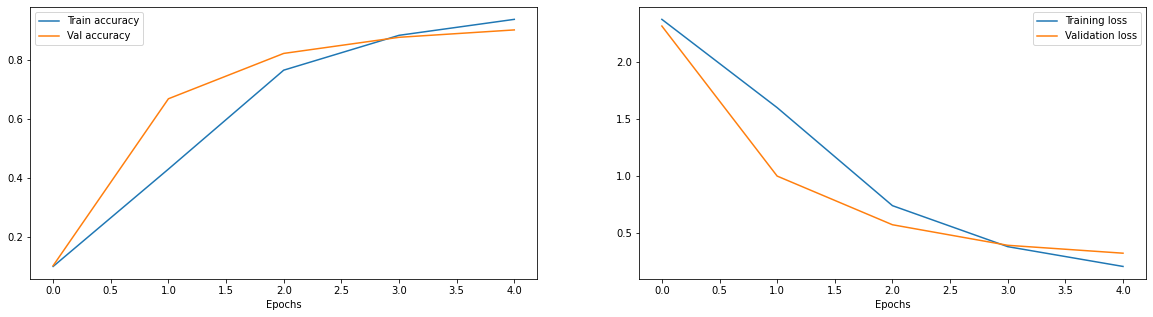

In [155]:
def plot_train_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))

    axes[0].plot(history.history['accuracy'], label='Train accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend() 

    axes[1].plot(history.history['loss'], label='Training loss')
    axes[1].plot(history.history['val_loss'], label='Validation loss')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

plot_train_history(history)
plt.show()

In [182]:
%cd /content

/content


In [272]:
# evaluate loss and accuracy in test dataset
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
dict(zip(model.metrics_names, model.evaluate(test_gen, steps=len(test_idx)//128)))

70/70 [==============================] - 72s 1s/step - loss: 0.3200 - accuracy: 0.8992


{'loss': 0.31996414065361023, 'accuracy': 0.8992466330528259}

In [271]:
def format_y(y):
    return ''.join(map(lambda x: chr(int(x)), y))

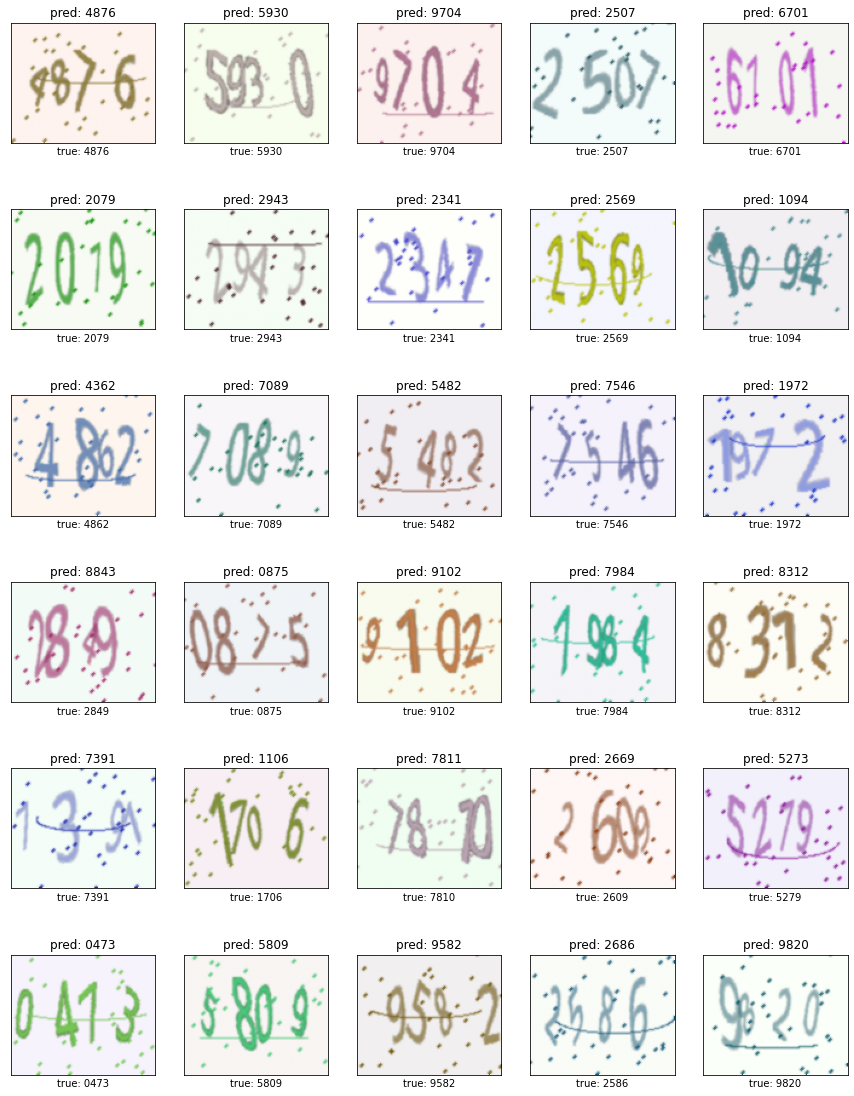

In [270]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
x_test, y_test = next(test_gen)

y_pred = model.predict_on_batch(x_test)

y_true = tf.math.argmax(y_test, axis=-1)
y_pred = tf.math.argmax(y_pred, axis=-1)

import math
n = 30
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(x_test[img_idx])
    ax.set_title('pred: %s' % format_y(y_pred[img_idx]))
    ax.set_xlabel('true: %s' % format_y(y_true[img_idx]))
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

# Evasion Attack

In [186]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##FGSM

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

sccLoss = SparseCategoricalCrossentropy()


def clip_eps(tensor, eps):
    # clip the values of the tensor to a given range and return it
    return tf.clip_by_value(tensor, clip_value_min=-eps,
                            clip_value_max=eps)
    
EPS = 2 / 255.0
LR = 0.1

optimizer = Adam(learning_rate=LR)

def generate_adversaries(model, baseImage, delta, y_true, steps=50):
    # iterate over the number of steps
    loss = 1
    loss = tf.convert_to_tensor([loss])
    for step in range(0, steps):
        # record our gradients
        with tf.GradientTape() as tape:
            # explicitly indicate that our perturbation vector should
            # be tracked for gradient updates
            tape.watch(delta)
            # add our perturbation vector to the base image and
            # preprocess the resulting image
            # adversary = preprocess_input(baseImage + delta)
            #print(adversary.shape)
            # run this newly constructed image tensor through our
            # model and calculate the loss with respect to the
            # *original* class index
            predictions = model(np.array([baseImage]))
            y_pred = tf.math.argmax(predictions, axis=-1)

            """loss = 0
            for i in range(len(y_true)):
              loss += abs(y_true[i]-y_pred[i]) / 100"""
            y_true_tensor = tf.convert_to_tensor(y_true)
            #loss = abs(y_pred-y_true_tensor)
            loss = loss+1
            print(loss)
            # check to see if we are logging the loss value, and if
            # so, display it to our terminal
            if step % 5 == 0:
                print("step: {}, loss: {}...".format(step,
                                                     loss.numpy()))
            # calculate the gradients of loss with respect to the
            # perturbation vector
        gradients = tape.gradient(loss, delta)
        # update the weights, clip the perturbation vector, and
        # update its value
        optimizer.apply_gradients([(gradients, delta)])
        delta.assign_add(clip_eps(delta, eps=EPS))
        # return the perturbation vector
    return delta

In [ ]:
"""baseImage = tf.constant(x_test[0], dtype=tf.float32)
delta = tf.Variable(tf.zeros_like(baseImage), trainable=False)
# generate the perturbation vector to create an adversarial example
print("[INFO] generating perturbation...")
deltaUpdated = generate_adversaries(model, x_test[0], delta, np.array([51,56,53,52]))"""

## Random Perturbation Method

In [187]:
black = [0,0,0]
blue = [0,0,1]

In [252]:
import random

x_chosen_arr = []
id_list = [61,91,93,4,65,8,119,1,120,78,64,48,38,55,83,84,53,44,11,80,120,55,23,64,78,88,3,76,22,4]

labels = []
for i in id_list:
  x_chosen_arr.append(x_test[i])
  labels.append(y_test[i])

In [286]:
evadedArr = []
for x_chosen in x_chosen_arr:
  background_color = x_chosen[0][0]
  modified_background_color = background_color * 0.99

  font_color = []
  for i in range(0, x_test.shape[1]):
    for j in range(x_test.shape[2]):
      if all(abs(x-y)>0.01 for x, y in zip(x_chosen[i][j], background_color)):
        font_color = x_chosen[i][j]


  evadedX = 100*[120*[3*[0.98]]]
  evadedX = np.array(evadedX)

  for i in range(0, x_test.shape[1]):
    for j in range(x_test.shape[2]):
      rand_num = random.randint(0,100)
      if rand_num == 0:
        evadedX[i][j] = modified_background_color
      else:
        evadedX[i][j] = x_chosen[i][j]

  evadedArr.append(evadedX)
evadedArr = np.array(evadedArr)

1/1 [==============================] - 0s 345ms/step
Acc:  0.8


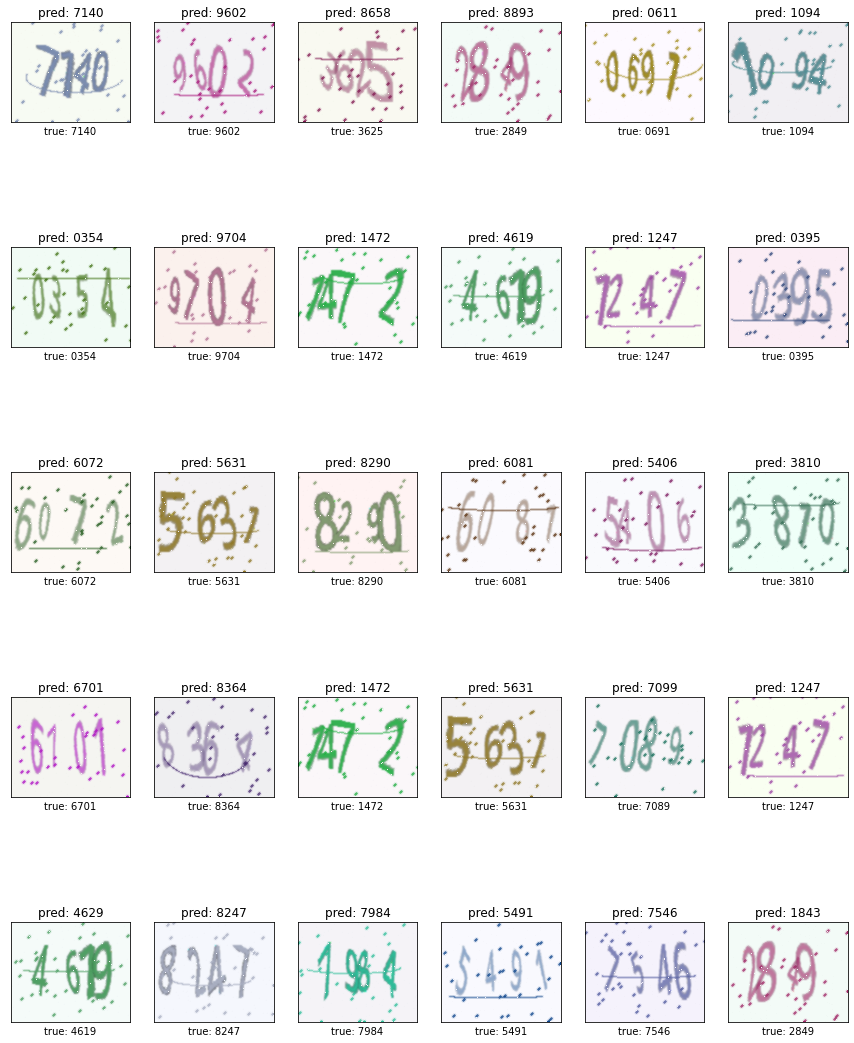

In [287]:
import math
n = 30
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_cols, n_rows, figsize=(15, 20))
counter = 0
true_count = 0

y_pred = model.predict(evadedArr)
y_pred = tf.math.argmax(y_pred, axis=-1)


for i in id_list:

    label = labels[counter]

    label = tf.math.argmax(label, axis=-1)
    label = format_y(label)

    y_res = y_pred.numpy()[counter]
    y_res = format_y(y_res)


    ax = axes.flat[counter]
    ax.imshow(evadedArr[counter])
    ax.set_title('pred: %s' % y_res)
    ax.set_xlabel('true: %s' % label)
    ax.set_xticks([])
    ax.set_yticks([])
    if label==y_res:
      true_count += 1

    counter += 1

accuracy = true_count / len(id_list)
print("Acc: ", accuracy)
plt.show()

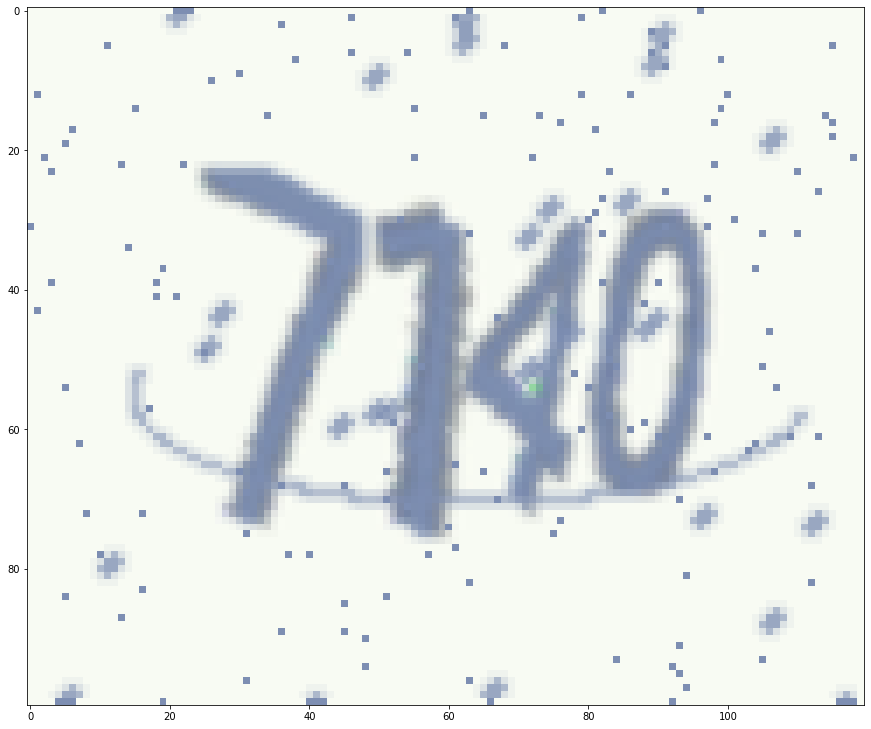

In [269]:
fig, ax = plt.subplots(1, 1, figsize=(15, 20))
ax.imshow(evadedArr[0])
plt.show()

In [230]:
%cd /content/drive/My Drive/adv_images/
adv_imgs_size = 6
imgs = []
imgs_np = np.array([])
for i in range(1, adv_imgs_size+1):
  filename = "adv{}.png".format(i)

  im = Image.open(filename)
  new_im = im.resize((120, 100))
  imgs.append(np.array(new_im))
  imgs_np = np.array(imgs)

imgs_np = imgs_np/255
y_pred_adv = model.predict_on_batch(imgs_np)
y_pred_adv = tf.math.argmax(y_pred_adv, axis=-1)
y_pred_adv

/content/drive/My Drive/adv_images


<tf.Tensor: shape=(6, 4), dtype=int64, numpy=
array([[48, 49, 50, 52],
       [49, 49, 50, 53],
       [55, 49, 57, 54],
       [48, 49, 50, 55],
       [54, 49, 50, 51],
       [48, 49, 50, 51]])>

In [231]:
for i in range(adv_imgs_size):
  out = format_y(y_pred_adv[i])
  print(out)

0124
1125
7196
0127
6123
0123


FGSM

In [288]:
# import the necessary packages
from tensorflow.keras.losses import MSE
import tensorflow as tf
def generate_image_adversary_FGSM(model, image, label, eps=2 / 255.0):
	# cast the image
	image = tf.cast(image, tf.float32)
 	# record our gradients
	with tf.GradientTape() as tape:
		# explicitly indicate that our image should be tacked for
		# gradient updates
		tape.watch(image)
		# use our model to make predictions on the input image and
		# then compute the loss
		pred = model(image)
		loss = MSE(label, pred)
  	# calculate the gradients of loss with respect to the image, then
	# compute the sign of the gradient
	gradient = tape.gradient(loss, image)
	signedGrad = tf.sign(gradient)
	# construct the image adversary
	adversary = (image + (signedGrad * eps)).numpy()
	# return the image adversary to the calling function
	return adversary

1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 33ms/step


Acc:  0.0


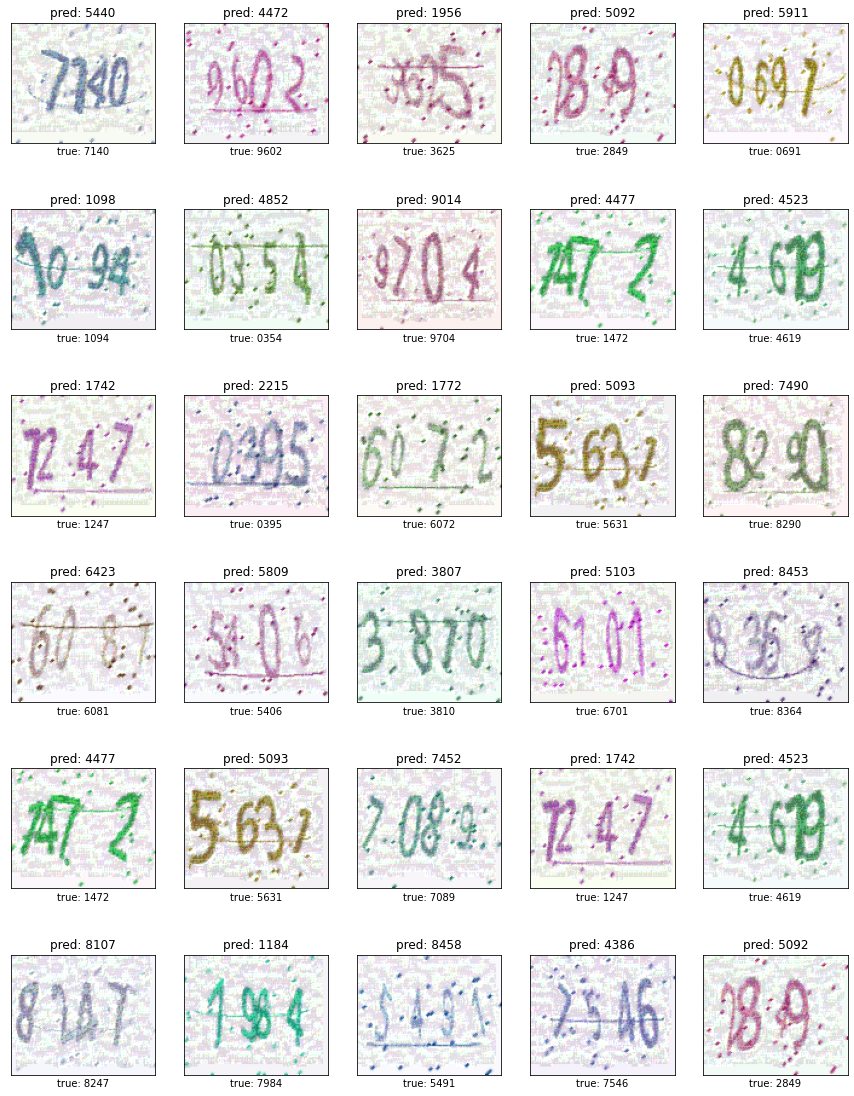

In [289]:
import math

def format_y(y):
    return ''.join(map(lambda x: chr(int(x)), y))

test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
x_test, y_test = next(test_gen)

id_list = [61,91,93,4,65,8,119,1,120,78,64,48,38,55,83,84,53,44,11,80,120,55,23,64,78,88,3,76,22,4]

import math
n = 30
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))
true_count = 0
flat_counter = 0
for i in id_list:
    image = x_test[i]
    label = y_test[i]

    adversary = generate_image_adversary_FGSM(model,np.array([image]), label, eps=0.1)
    y_pred = model.predict(adversary)

    label = tf.math.argmax(label, axis=-1)
    label = format_y(label)

    y_pred = tf.math.argmax(y_pred, axis=-1)
    y_pred = y_pred.numpy()[0]
    y_pred = format_y(y_pred)

    adversary=adversary.reshape(100,120,3)

    ax = axes.flat[flat_counter]
    ax.imshow(adversary)
    ax.set_title('pred: %s' % y_pred)
    ax.set_xlabel('true: %s' % label)
    ax.set_xticks([])
    ax.set_yticks([])
    flat_counter += 1
    if y_pred == label:
      true_count += 1

acc = true_count / len(id_list)
print("Acc: ", acc)
plt.show()

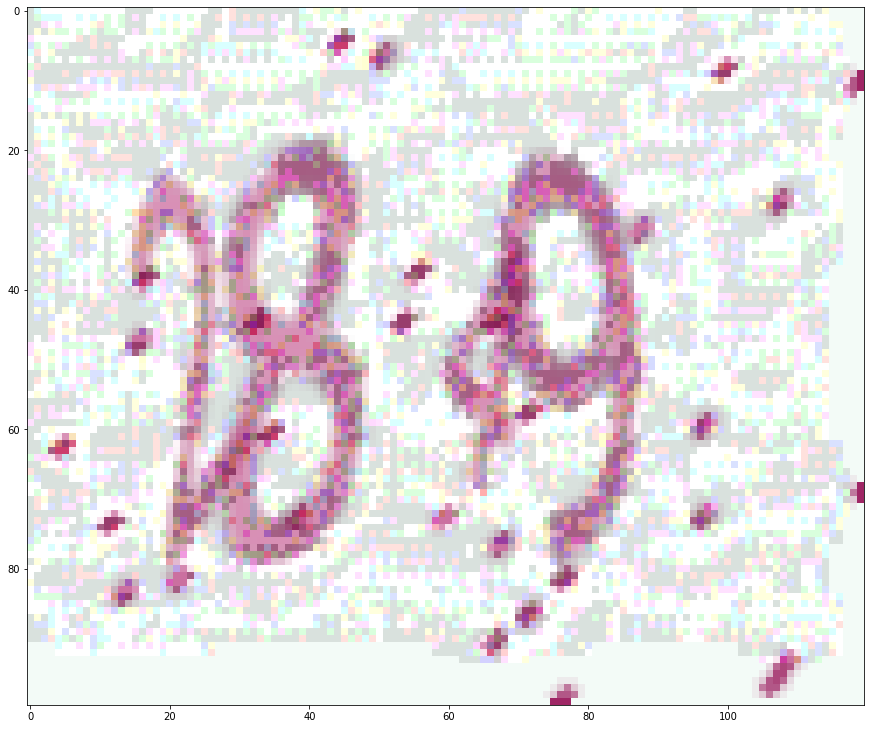

In [280]:
fig, ax = plt.subplots(1, 1, figsize=(15, 20))
ax.imshow(adversary)
plt.show()